In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import dask

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision.utils import _log_api_usage_once
from torchvision.models.resnet import BasicBlock, Bottleneck, conv1x1

from typing import Callable, Type
from torch import Tensor

In [2]:
dask.config.set(scheduler='synchronous')

In [3]:
def coarsen(da: xr.DataArray, factor: int = 10, reduction: str = 'mean') -> xr.DataArray:
    return getattr(da.coarsen(x=factor, y=factor, boundary='trim'), reduction)().compute()

def count_trainable_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
class BaseAugmentor(object):
    """Base augmentator class.

    - Meant to be subclassed.
    - Method `augment` must be overridden in subclas.
    """
    def set_seed(self, random_seed) -> None:
        self.RS = np.random.RandomState(seed=random_seed)

    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """

        raise NotImplementedError(
            'you must override this method in the subclass.'
        )

    def set_random_state(self, random_seed: int) -> None:
        self.random_state = np.random.RandomState(seed=random_seed)

    @property
    def random_state(self) -> np.random.RandomState:
        if not hasattr(self, '_random_state'):
            raise AttributeError('attribute `random_state` is not set. Use `set_random_state`.')
        else:
            return self._random_state
    
    @random_state.setter 
    def random_state(self, random_state: np.random.RandomState) -> None:
        if not isinstance(random_state, np.random.RandomState):
            raise TypeError(
                f'`random_state` must be of type `np.random.RandomState`, is `{type(random_state).__name__}`.'
            )
        self._random_state = random_state


class FlipAugmentor(BaseAugmentor):
    """Random flip x and y dimensions."""
    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array using random horizontal and vertical flipping.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """

        flip_vertical = self.random_state.randint(0, 2)
        flip_horizontal = self.random_state.randint(0, 2)

        flip_axes = []
        if flip_vertical:
            flip_axes.append(0)

        if flip_horizontal:
            flip_axes.append(1)

        if len(flip_axes) > 0:
            cutout = np.flip(cutout, axis=flip_axes)

        return cutout

    def __repr__(self) -> str:
        return 'FlipAugmentor()'


class RotateAugmentor(BaseAugmentor):
    """Random rotate spatial dimensions."""
    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array using random rotation flipping.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """
        num_rotate = self.random_state.randint(0, 4)

        cutout = np.rot90(cutout, k=num_rotate, axes=(0, 1))

        return cutout

    def __repr__(self) -> str:
        return 'RotateAugmentor()'


class PixelNoiseAugmentor(BaseAugmentor):
    """Random noise at pixel level."""
    def __init__(self, scale: float) -> None:
        """Init PixelNoiseAugmentor.
        
        Args:
            scale: scale of noise.
        """
        self.scale = scale

    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array using pixel-level noise.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """
        random_noise = self.random_state.randn(*cutout.shape) * self.scale

        return cutout + random_noise

    def __repr__(self) -> str:
        return f'PixelNoiseAugmentor(scale={self.scale})'


class ChannelNoiseAugmentor(BaseAugmentor):
    """Random noise at channel level."""
    def __init__(self, scale: float) -> None:
        """Init ChannelNoiseAugmentor.
        
        Args:
            scale: scale of noise.
        """
        self.scale = scale

    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array using channel-level noise.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """
        random_noise = self.random_state.randn(cutout.shape[2]) * self.scale

        return cutout + random_noise[np.newaxis, np.newaxis, ...]

    def __repr__(self) -> str:
        return f'ChannelNoiseAugmentor(scale={self.scale})'


class AugmentorChain(object):
    def __init__(self, random_seed: int, augmentors: list[BaseAugmentor] | None) -> None:
        self.random_seed = random_seed
        self.augmentors = augmentors

        if self.augmentors is not None:
            for augmentor in self.augmentors:
                augmentor.set_random_state(random_seed)

    def augment(self, cutout: np.ndarray) -> np.ndarray:

        if self.augmentors is None:
            return cutout

        for augmentor in self.augmentors:
            cutout = augmentor.augment(cutout)

        return cutout

    def __repr__(self) -> str:
        if self.augmentors is None:
            return f'AugmentorChain(augmentors=None)'

        autmentors_repr = [str(augmentor) for augmentor in self.augmentors]
        return f'AugmentorChain(random_seed={self.random_seed}, augmentors=[{", ".join(autmentors_repr)}])'


In [5]:
class RSData(Dataset):
    def __init__(
            self,
            ds_path: str,
            mask_area: list[int] | int,
            cutout_size: int = 21,
            rs_means: xr.DataArray | None = None,
            rs_stds: xr.DataArray | None = None,
            augmentor_chain: AugmentorChain | None = None):

        super().__init__()

        # TODO: limit cutout

        self.ds = xr.open_zarr(ds_path)

        if cutout_size % 2 == 0:
            raise ValueError('`cutout_size` must be an odd integer.')

        self.mask_values = self.get_mask_values(mask_area)

        self.cutout_size = cutout_size

        self.mask = self.ds.mask.isin(self.mask_values).compute()

        self.coords = np.argwhere(self.mask.values)

        if (rs_means is None) != (rs_stds is None):
            raise ValueError(
                'either pass both of `rs_means` and `rs_stds` or none.'    
            )

        if rs_means is None:
            rs_means = self.ds.rs.where(self.mask).mean(('x', 'y')).compute()
            rs_stds = self.ds.rs.where(self.mask).std(('x', 'y')).compute()

        self.rs_means = rs_means
        self.rs_stds = rs_stds

        if augmentor_chain is None:
            self.augmentor_chain = AugmentorChain(random_seed=0, augmentors=[])
        else:
            self.augmentor_chain = augmentor_chain

    def get_mask_values(self, mask_area: list[int] | int) -> np.ndarray:
        mask_area_ = np.array([mask_area] if isinstance(mask_area, int) else mask_area)

        if any(mask_area_ < 0) or any(mask_area_ > 4):
            raise ValueError('`mask_values` must be in range [0, ..., 4]')

        mask_values = np.argwhere(np.isin((np.arange(1, 13) - 1) % 4, mask_area_ - 1)).flatten() + 1

        if any(mask_area_ == 0):
            mask_values = np.concatenate((mask_values, np.zeros(1, dtype=int)))

        return mask_values

    def __len__(self) -> int:
        return len(self.coords)

    def __getitem__(self, index: int):
        x_i, y_i = self.coords[index]

        offset = int(self.cutout_size // 2)

        cutout = self.ds.rs.isel(
            x=slice(x_i - offset, x_i + offset + 1),
            y=slice(y_i - offset, y_i + offset + 1),
        )

        # Standardize.
        cutout = (cutout - self.rs_means) / self.rs_stds

        # Transpose, make sure x and y are first dimensions.
        cutout = cutout.transpose('x', 'y', ...).values

        # Augment.
        cutout = self.augmentor_chain.augment(cutout)

        # Put channel on first dimension, from (x, y, c) to (c, x, y).
        cutout = cutout.transpose(2, 0, 1)

        label_sel = self.ds.label.isel(
            x=x_i,
            y=y_i,
        ).values

        return cutout.astype('float32'), label_sel.astype('int')


In [6]:
class ResNet(nn.Module):
    """ResNet model.

    https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
    """
    def __init__(
        self,
        block: Type[BasicBlock | Bottleneck] = BasicBlock,
        layers: list[int] = [2, 2, 2],
        inplanes: int = 8,  # Changed to accept inplanes as argument.
        num_classes: int = 9,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: list[bool] | None = None,
        norm_layer: Callable[..., nn.Module] | None= None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = inplanes
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        # Changed the first layer to accept 4 channels.
        self.conv1 = nn.Conv2d(4, self.inplanes, kernel_size=3, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, inplanes, layers[0])
        self.layer2 = self._make_layer(block, inplanes * 2, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, inplanes * 4, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.inplanes * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[BasicBlock | Bottleneck],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [7]:
ac = AugmentorChain(
    random_seed=1,
    augmentors=[
        FlipAugmentor(),
        RotateAugmentor(),
        PixelNoiseAugmentor(scale=0.1),
        ChannelNoiseAugmentor(scale=0.1)
    ]
)

rsdata_train = RSData(
    '../data/combined.zarr',
    mask_area=[1],
    cutout_size=21,
    augmentor_chain=ac
)

rsdata_valid = RSData(
    '../data/combined.zarr',
    mask_area=[2],
    cutout_size=21,
    augmentor_chain=ac,
    rs_means=rsdata_train.rs_means,
    rs_stds=rsdata_train.rs_stds
)

In [11]:
train_dl = DataLoader(rsdata_train, batch_size=40, shuffle=True, num_workers=2)
# valid_dl = DataLoader(rsdata_valid, batch_size=40, shuffle=False, num_workers=2)

In [9]:
it = iter(train_dl)

In [10]:
%%time
next(it)

CPU times: total: 1.08 s
Wall time: 2.09 s


[tensor([[[[ 3.6354e+00,  3.4522e+00,  3.4630e+00,  ...,  1.3595e+00,
             9.6903e-01,  4.1751e-01],
           [ 3.5133e+00,  3.5123e+00,  3.4112e+00,  ...,  1.2733e+00,
             7.6277e-01,  2.5927e-01],
           [ 3.7376e+00,  3.9469e+00,  3.6737e+00,  ...,  1.2430e+00,
             5.1967e-01,  3.4966e-01],
           ...,
           [ 3.3353e+00,  2.8920e+00,  3.0712e+00,  ...,  2.2625e-01,
             3.6439e-01,  1.4248e-01],
           [ 3.0286e+00,  3.1251e+00,  3.0583e+00,  ...,  4.3633e-01,
             1.7086e-01,  3.9235e-01],
           [ 3.1526e+00,  2.9463e+00,  3.3970e+00,  ...,  2.9414e-01,
             5.9175e-02,  2.2059e-01]],
 
          [[ 4.0240e+00,  3.8758e+00,  3.9699e+00,  ...,  3.3235e+00,
             2.2062e+00,  9.0288e-01],
           [ 4.1866e+00,  4.2637e+00,  4.2374e+00,  ...,  3.4039e+00,
             1.5860e+00,  7.2793e-01],
           [ 4.1032e+00,  4.1714e+00,  4.3606e+00,  ...,  2.9802e+00,
             1.5332e+00,  5.3839e-01],


In [ ]:
for batch in train_dl:
    print('---')

In [9]:
train_dl = DataLoader(rsdata_train, batch_size=40, shuffle=True, num_workers=2)
valid_dl = DataLoader(rsdata_valid, batch_size=40, shuffle=False, num_workers=2)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10
num_epochs = 2
# batch_size = 16
learning_rate = 0.01

# Model
model = ResNet(inplanes=4, num_classes=num_classes).to(device)
print('Number of trainable parameters: ', count_trainable_parameters(model))

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.000, momentum=0.9)  


Number of trainable parameters:  11410


In [ ]:
total_step = len(train_dl)

for epoch in range(num_epochs):
    for i, (images, labels) in tqdm(enumerate(train_dl), total=total_step, desc=f'Epoch {epoch+1}/{num_epochs} (train)'):  
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    #Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

In [65]:
def count_trainable_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [69]:
count_trainable_parameters(resnet)

2741537

In [320]:
rs, label = rsdata[0]

In [325]:
rsdata.ds.rs.max().compute()

<xarray.DataArray 'rs' ()> Size: 2B
array(65535, dtype=uint16)
Coordinates:
    spatial_ref  int64 8B 0

In [328]:
rs.shape

(21, 21, 4)

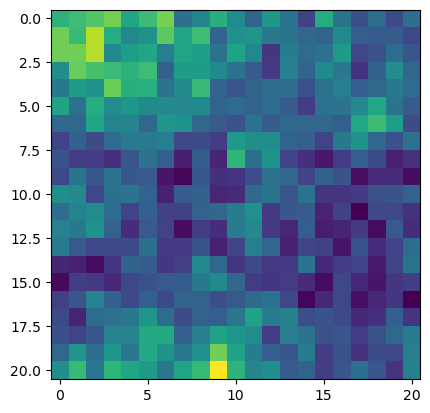

In [334]:
plt.imshow(rs[..., 3])

In [263]:
c.transpose('x', 'y', ...).values

array([[[2056,  671,  832,  814],
        [1955,  739,  838,  830],
        [2326,  679,  983,  846],
        ...,
        [2391,  483,  792,  706],
        [2408,  369,  749,  657],
        [2381,  463,  736,  707]],

       [[1784,  744,  839,  864],
        [1824,  782,  824,  825],
        [2088,  746,  956,  905],
        ...,
        [2373,  502,  805,  682],
        [2403,  398,  857,  681],
        [2392,  454,  745,  653]],

       [[1839,  691,  838,  865],
        [1946,  684,  864,  865],
        [2241,  746, 1036,  904],
        ...,
        [2546,  476,  817,  666],
        [2329,  407,  794,  708],
        [2281,  496,  838,  672]],

       ...,

       [[2258,  376,  827,  665],
        [2064,  381,  789,  650],
        [1959,  298,  762,  676],
        ...,
        [2569,  516,  844,  666],
        [2591,  527,  863,  698],
        [2430,  502,  732,  725]],

       [[2677,  462,  887,  699],
        [2539,  590,  937,  767],
        [2099,  499,  699,  711],
        .

In [246]:
rsdata[0]

ValueError: Dimensions {'y', 'x'} do not exist. Expected one or more of ()

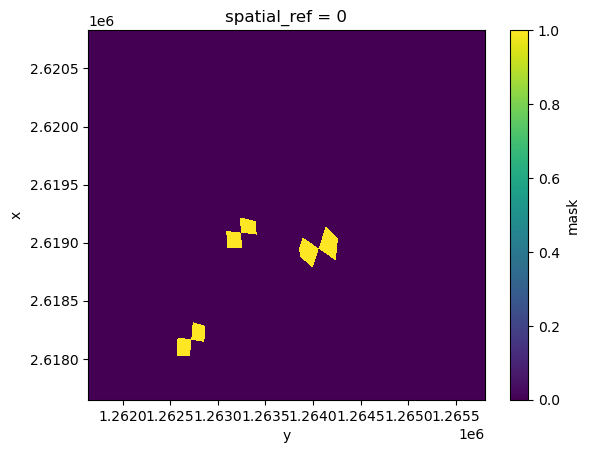

In [172]:
coarsen(rsdata.mask, reduction='max').plot()

In [370]:
x.transpose(2, 0, 1)

array([[[0, 1],
        [2, 3]]])